In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

import warnings
warnings.simplefilter(action='ignore')

In [2]:

df=pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


***Extracting titles from Name column***

In [3]:
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.')

In [4]:
df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Mme           1
Countess      1
Capt          1
Don           1
Sir           1
Jonkheer      1
Ms            1
Lady          1
Name: Title, dtype: int64

In [5]:
df['Title']=df['Title'].replace({'Mlle':'Miss', 'Ms': 'Miss', 'Mme':'Mrs'})

In [6]:
l=['Master','Miss','Mr','Mrs']
for i in df['Title']:
    if i not in l:
        df['Title'].replace(i,'Other', inplace=True)        

In [7]:
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

## EDA

***Age***

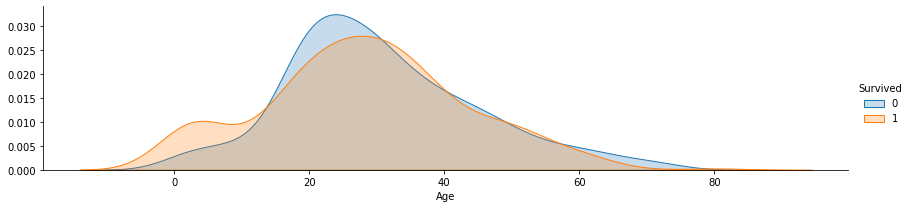

In [8]:
a = sns.FacetGrid( df, hue = 'Survived',  aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.add_legend()

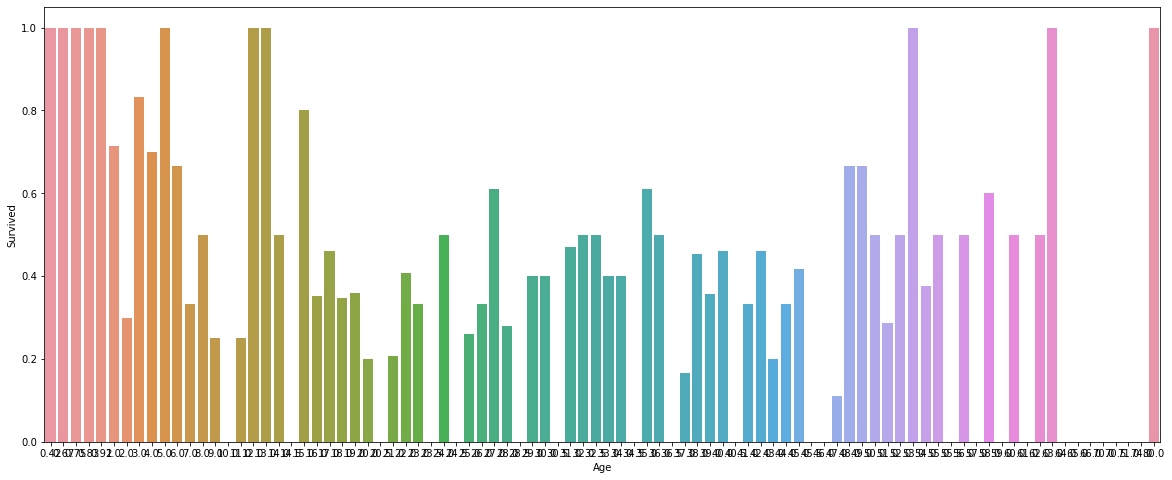

In [9]:
age=df[["Survived",'Age']].groupby('Age', as_index=False).mean()
plt.figure(figsize=(20,8))
sns.barplot('Age','Survived', data=age);

***Fare***

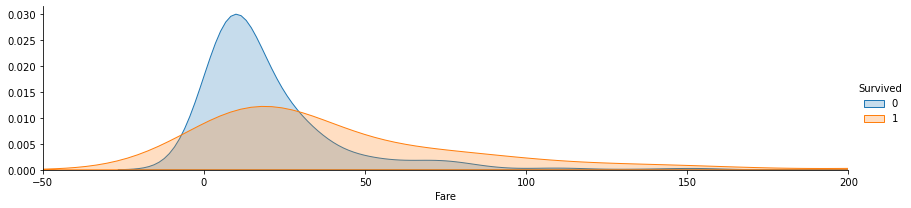

In [10]:
a = sns.FacetGrid( df, hue = 'Survived',  aspect=4 )
a.map(sns.kdeplot, 'Fare', shade= True )
a.add_legend()
a.set(xlim=(-50,200))

***Sex***

In [11]:
df.groupby('Sex')[["Survived"]].mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


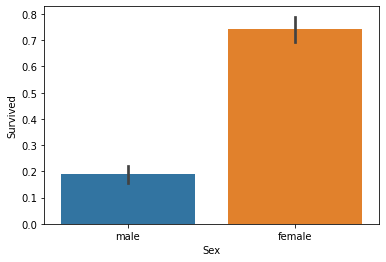

In [12]:
sns.barplot('Sex', 'Survived', data=df);

***Embarked***

In [13]:
df.groupby('Embarked')[["Survived"]].mean().sort_values(by='Survived', ascending=False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

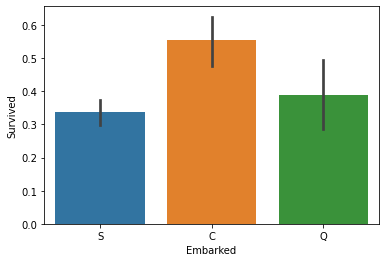

In [14]:
sns.barplot('Embarked','Survived', data=df)

***Pclass***

In [15]:
df.groupby('Pclass')[["Survived"]].mean().sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

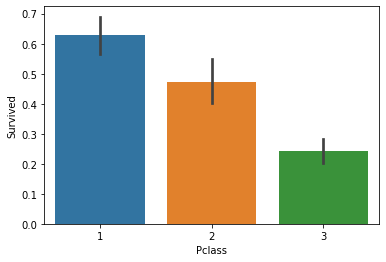

In [16]:
sns.barplot('Pclass', 'Survived', data=df)

***SibSp***

In [17]:
df.groupby('SibSp')[["Survived"]].mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

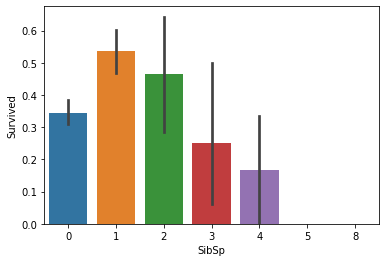

In [18]:
sns.barplot('SibSp', 'Survived', data=df)

***Parch***

In [19]:
df.groupby('Parch')[["Survived"]].mean().sort_values(by='Survived', ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


<AxesSubplot:xlabel='Parch', ylabel='Survived'>

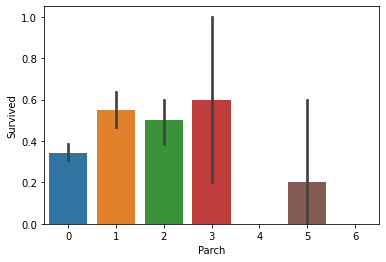

In [20]:
sns.barplot('Parch', 'Survived', data=df)

***Feature engineering***

In [8]:
X=df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)

In [9]:
y=df.Survived

In [10]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
trans = ColumnTransformer([
    ('impute and scale age', make_pipeline(SimpleImputer(strategy='median', missing_values=np.nan), 
                                       MinMaxScaler(), KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile')), ['Age', 'Fare']),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Pclass','Sex', 'Title']),
    ('impute and split', make_pipeline(SimpleImputer(strategy='most_frequent',missing_values=np.nan), OneHotEncoder(sparse=False, handle_unknown='ignore')), ['Embarked']),
    ('do_nothing', 'passthrough', ['Parch', 'SibSp']),
])

In [13]:
trans.fit(X_train)                    # DataFrame with titanic data
Xtrain_fe = trans.transform(X_train)  # use this to train your model
Xtest_fe = trans.transform(X_test)    # DataFrame for prediction

## LogisticRegression Model

In [14]:

log_model = LogisticRegression()
log_model.fit(Xtrain_fe, y_train)
log_model.score(Xtrain_fe, y_train)

0.8383233532934131

In [15]:
acc_log_reg=round(log_model.score(Xtest_fe,y_test),3)
acc_log_reg

0.834

In [28]:
y_pred = log_model.predict(Xtest_fe)

In [29]:
confusion_matrix(y_test,y_pred)

array([[116,  18],
       [ 19,  70]])

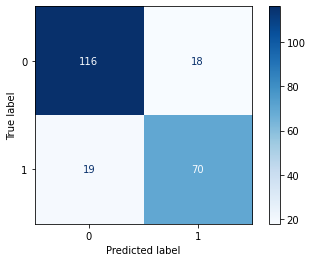

In [30]:
plot_confusion_matrix(log_model, Xtest_fe, y_test,cmap=plt.cm.Blues)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       134
           1       0.80      0.79      0.79        89

    accuracy                           0.83       223
   macro avg       0.83      0.83      0.83       223
weighted avg       0.83      0.83      0.83       223



## DecisionTree Model

In [32]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [33]:
tree_model=DecisionTreeClassifier(max_depth=3)

In [34]:
tree_model.fit(Xtrain_fe, y_train)
tree_model.score(Xtrain_fe, y_train)


0.8248502994011976

In [35]:
acc_decision_tree=round(tree_model.score(Xtest_fe,y_test),3)
acc_decision_tree

0.821

In [36]:
y_pred = tree_model.predict(Xtest_fe)

In [37]:
confusion_matrix(y_test,y_pred)

array([[114,  20],
       [ 20,  69]])

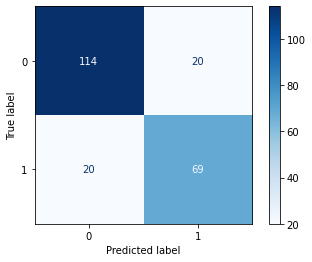

In [38]:
plot_confusion_matrix(tree_model, Xtest_fe, y_test,cmap=plt.cm.Blues)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       134
           1       0.78      0.78      0.78        89

    accuracy                           0.82       223
   macro avg       0.81      0.81      0.81       223
weighted avg       0.82      0.82      0.82       223



## RandomForest Model

In [40]:
for_model = RandomForestClassifier(n_estimators=100, max_depth=6)

In [41]:
for_model.fit(Xtrain_fe, y_train)
for_model.score(Xtrain_fe, y_train)

0.8607784431137725

In [42]:
acc_random_forest=round(for_model.score(Xtest_fe,y_test),3)
acc_random_forest

0.83

In [43]:
y_pred = for_model.predict(Xtest_fe)

In [44]:
confusion_matrix(y_test,y_pred)

array([[117,  17],
       [ 21,  68]])

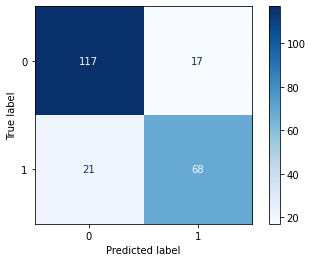

In [45]:
plot_confusion_matrix(for_model, Xtest_fe, y_test,cmap=plt.cm.Blues)

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       134
           1       0.80      0.76      0.78        89

    accuracy                           0.83       223
   macro avg       0.82      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223



## Catboost

In [18]:
from catboost import CatBoostClassifier, Pool, metrics

In [116]:
cat_model = CatBoostClassifier(iterations=55,
    custom_loss=[metrics.Accuracy()], logging_level='Silent')

In [117]:

cat_model.fit(Xtrain_fe, y_train,eval_set=(Xtest_fe,y_test), plot=True)
cat_model.score(Xtrain_fe, y_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8727544910179641

In [118]:
acc_cat_model=round(cat_model.score(Xtest_fe,y_test),3)
acc_cat_model

0.825

In [119]:
y_pred = cat_model.predict(Xtest_fe)

In [120]:
confusion_matrix(y_test,y_pred)

array([[118,  16],
       [ 23,  66]])

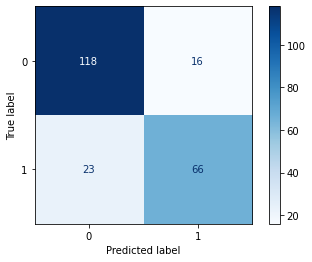

In [121]:
plot_confusion_matrix(cat_model, Xtest_fe, y_test,cmap=plt.cm.Blues)

In [122]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       134
           1       0.80      0.74      0.77        89

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.82       223
weighted avg       0.82      0.83      0.82       223



## Models evaluation

In [123]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'CatBoost'],
    
    'Score': [acc_log_reg, acc_decision_tree, acc_random_forest,acc_cat_model]
    })

models.sort_values(by='Score', ascending=False,)

,Model,Score
0,Logistic Regression,0.834
2,Random Forest,0.830
3,CatBoost,0.825
1,Decision Tree,0.821


***ROC Curve***

In [129]:
from sklearn import metrics

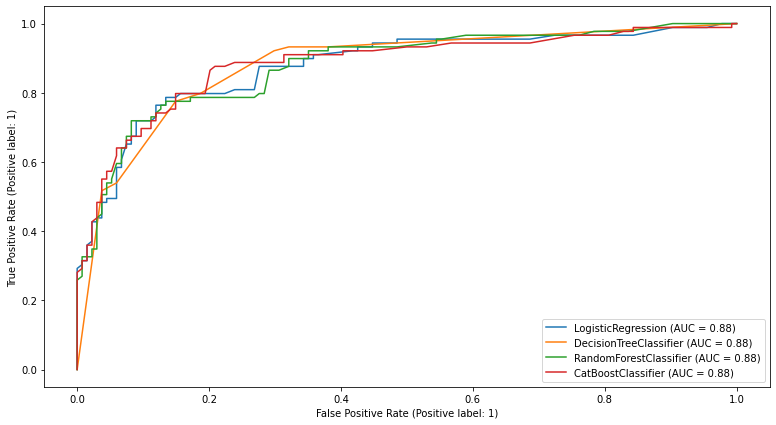

In [131]:
fig, axes = plt.subplots(1,1, figsize=(13,7))
metrics.plot_roc_curve(log_model, Xtest_fe, y_test, ax=axes)
metrics.plot_roc_curve(tree_model, Xtest_fe, y_test,ax=axes)
metrics.plot_roc_curve(for_model, Xtest_fe, y_test, ax=axes)
metrics.plot_roc_curve(cat_model, Xtest_fe, y_test, ax=axes)